In [206]:
import numpy as np
import matplotlib.pyplot as plt

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import HiCOLA.Frontend.numerical_solver as ns
import HiCOLA.Frontend.expression_builder as eb
import os
import time
import itertools as it
from multiprocessing import Pool
from HiCOLA.Frontend.read_parameters import read_in_scan_parameters, read_in_scan_settings
from argparse import ArgumentParser
from configobj import ConfigObj
from pathlib import Path
import shutil


In [208]:
# Initialisation
##############
symbol_decl = eb.declare_symbols()
exec(symbol_decl)
odeint_parameter_symbols = [E, phiprime, omegar, omegam]
######################


In [209]:
symbol_decl

'a, E, Eprime, phi, phiprime, phiprimeprime, X,  M_pG4, M_KG4, M_G3s, M_sG4, M_G3G4, M_Ks, M_gp, omegar, omegam, omegal, f_phi, Theta, threshold, threshold_sign = sym.symbols("a E Eprime phi phiprime phiprimeprime X M_{pG4} M_{KG4} M_{G3s} M_{sG4} M_{G3G4} M_{Ks} M_{gp} Omega_r Omega_m Omega_l f_phi Theta threshold threshold_sign")'

In [210]:
# Read imput parameters from files
# parser = ArgumentParser(prog='Scanner')
# parser.add_argument('input_ini_filenames',nargs=2)

# args = parser.parse_args()
# filenames = args.input_ini_filenames
scan_settings_path = '/Users/bartolomeo/GitHub/Hi-COLA_scanner/HiCOLA/Utilities/Scanner/scan_settings.ini'
scan_values_path = '/Users/bartolomeo/GitHub/Hi-COLA_scanner/HiCOLA/Utilities/Scanner/scan_parameters.ini'


scan_ini_path = Path(scan_settings_path).resolve()
scan_param_path = Path(scan_values_path).resolve()

scan_settings_dict = read_in_scan_settings(scan_settings_path)
scan_settings_dict.update({'odeint_parameter_symbols':odeint_parameter_symbols})

N_proc = scan_settings_dict['processor_number']

read_scan_values_from_file = scan_settings_dict['scan_values_from_file']

In [211]:

scan_values_dict = read_in_scan_parameters(scan_values_path)
[U0_array, phi0_array, phiprime0_array] = scan_values_dict['initial_condition_arrays']
[Omega_r0_array, Omega_m0_array, Omega_l0_array] = scan_values_dict['cosmological_parameter_arrays']
parameter_arrays = scan_values_dict['Horndeski_parameter_arrays']
number_of_horndeski_parameters = len(parameter_arrays)

['-0.11442716734931437', '-0.11442716734931437', '1']
['-0.29293354841424546', '-0.29293354841424546', '1']
['-1.9452618449383468', '-1.9452618449383468', '1']
['1.0405243750964335', '1.0405243750964335', '1']


In [212]:
parameter_arrays

[array([-0.11442717]),
 array([-0.29293355]),
 array([-1.94526184]),
 array([1.04052438])]

In [213]:


proto_scan_list = it.product(U0_array, phi0_array, phiprime0_array, Omega_r0_array,Omega_m0_array,Omega_l0_array,*parameter_arrays)
scan_list = []
for i in list(proto_scan_list):
    Hubble0, phi0, phiprime0, Omegar0, Omegam0, Omegal0 = i[:6]
    horndeski_parameters = i[6:]
    j = [Hubble0, phi0, phiprime0, Omegar0, Omegam0, Omegal0, horndeski_parameters, scan_settings_dict]
    scan_list.append(j)


model = scan_settings_dict['model_name']


In [311]:
f_phi = 1
Om = 0.3
Ol = (1-Om)*(1-f_phi)

In [340]:
# Hubble0, phi0, phi_prime0, Omega_r0, Omega_m0,Omega_l0, parameters, settings_dict = scan_list[0]
Hubble0, phi0, phi_prime0, Omega_r0, Omega_m0,Omega_l0, parameters, settings_dict = (
70,     10,      1,          0,          Om,    Ol,      [1,   0.3 ],  scan_settings_dict)

In [341]:
G3

In [342]:
# Hubble0, phi0, phi_prime0, Omega_r0, Omega_m0,Omega_l0, parameters, settings_dict = scan_list[0]

read_out_dict = scan_settings_dict.copy()

K = scan_settings_dict['K']
G3 = scan_settings_dict['G3']
G4 = scan_settings_dict['G4']
mass_ratio_list = scan_settings_dict['mass_ratio_list']
symbol_list = scan_settings_dict['symbol_list']

lambdified_functions = eb.create_Horndeski(K,G3,G4,symbol_list,mass_ratio_list)
E_prime_E_lambda = lambdified_functions['E_prime_E_lambda']
B2_lambda = lambdified_functions['B2_lambda']

read_out_dict.update(lambdified_functions)



cosmological_parameters = [Omega_r0, Omega_m0, Omega_l0]
initial_conditions = [Hubble0, phi0, phi_prime0]
repack_dict = {'cosmological_parameters':cosmological_parameters, 'initial_conditions':initial_conditions, 'Horndeski_parameters':parameters}
read_out_dict.update(repack_dict)




background_quantities = ns.run_solver(read_out_dict)

In [343]:
background_quantities.keys()

dict_keys(['a', 'Hubble', 'Hubble_prime', 'E_prime_E', 'scalar', 'scalar_prime', 'scalar_primeprime', 'omega_m', 'omega_r', 'omega_l', 'omega_phi', 'omega_DE', 'omega_m_prime', 'omega_r_prime', 'omega_l_prime', 'A', 'calB', 'calC', 'coupling_factor', 'chi_over_delta', 'closure_value', 'closure_declaration', 'closure_full'])

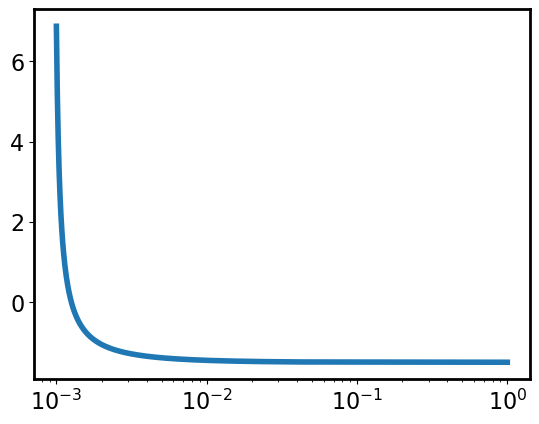

In [344]:
plt.plot(background_quantities['a'],background_quantities['E_prime_E'])
plt.xscale('log')

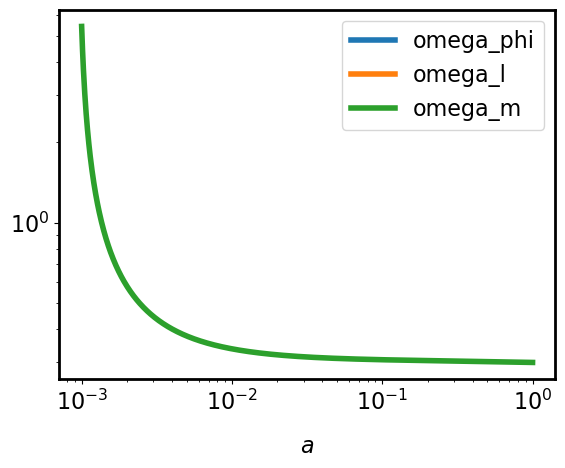

In [345]:
plt.plot(background_quantities['a'],(background_quantities['omega_phi']), label='omega_phi')
plt.plot(background_quantities['a'],background_quantities['omega_l'], label='omega_l')
plt.plot(background_quantities['a'],background_quantities['omega_m'], label='omega_m')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$a$')
# plt.ylabel('')
plt.legend()

In [346]:
# phi0_scalar = background_quantities['scalar']

In [347]:
phi0_scalar-background_quantities['scalar']

array([-10.        , -10.0018383 , -10.00366826, -10.00548991,
       -10.00730326, -10.00910834, -10.01090516, -10.01269375,
       -10.01447411, -10.01624628, -10.01801028, -10.01976612,
       -10.02151382, -10.02325341, -10.0249849 , -10.02670832,
       -10.0284237 , -10.03013104, -10.03183038, -10.03352173,
       -10.03520512, -10.03688056, -10.03854809, -10.04020773,
       -10.04185949, -10.0435034 , -10.04513948, -10.04676776,
       -10.04838827, -10.05000101, -10.05160602, -10.05320332,
       -10.05479294, -10.05637489, -10.05794921, -10.05951592,
       -10.06107503, -10.06262658, -10.06417059, -10.06570709,
       -10.0672361 , -10.06875764, -10.07027174, -10.07177842,
       -10.07327772, -10.07476965, -10.07625424, -10.07773151,
       -10.0792015 , -10.08066422, -10.08211971, -10.08356798,
       -10.08500907, -10.08644299, -10.08786978, -10.08928946,
       -10.09070206, -10.0921076 , -10.09350611, -10.09489762,
       -10.09628215, -10.09765972, -10.09903037, -10.10

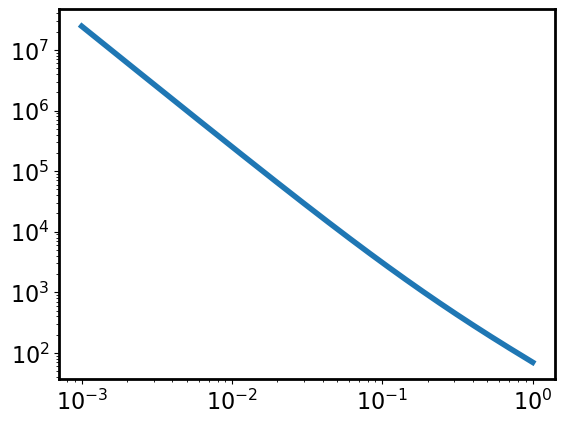

In [336]:
plt.loglog(background_quantities['a'],background_quantities['Hubble'])

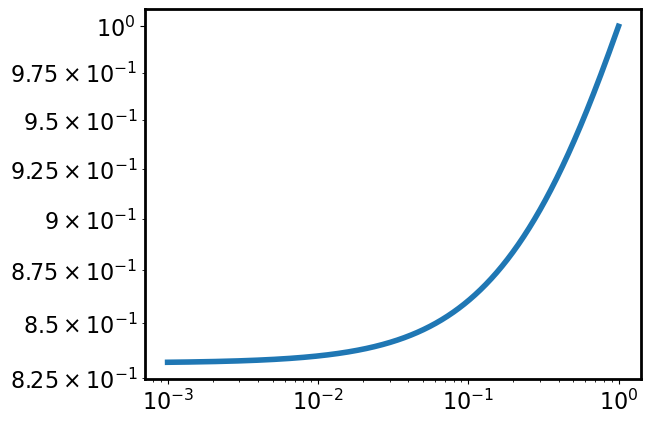

In [337]:
plt.loglog(background_quantities['a'],background_quantities['scalar'])

In [338]:
background_quantities['omega_phi']+background_quantities['omega_m']+background_quantities['omega_r']+background_quantities['omega_l']

array([1.        , 1.00000001, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999998, 0.99999998, 0.99999998,
       0.99999998, 0.99999998, 0.99999998, 0.99999998, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     